# Extracción de trazas en Kyber

## Configuración del chipwhisperer

Los cuatro siguientes bloques de código cargan el programa en el chipwhisperer.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
import chipwhisperer as cw
scope = cw.scope()
scope.default_setup()

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 2236324                   to 24379241                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 0                         to 29538459                 
scope.clock.adc_rate                     changed from 0.0                       to 29538459.0               
scope.clock.clkgen_

In [2]:
target = cw.target(scope, cw.targets.SimpleSerial)

In [3]:
%%bash -s "$PLATFORM"
cd ../firmware/mcu/kyber
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:13.2.rel1-2) 13.2.1 20231009
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-kyber.c ...
-e Done!
.
Compiling:
-en     cbd.c ...
-e Done!
.
Compiling:
-en     fips202.c ...
-e Done!
.
Compiling:
-en     indcpa.c ...
-e Done!
.
Compiling:
-en     kem.c ...
-e Done!
.
Compiling:
-en     ntt.c ...
-e Done!
.
Compiling:
-en     poly.c ...
-e Done!
.
Compiling:
-en     polyvec.c ...
-e Done!
.
Compiling:
-en     reduce.c ...
-e Done!
.
Compiling:
-en     rng.c ...
-e Done!
.
Compiling:
-en     sha256.c ...
-e Done!
.
Compiling:
-en     symmetric-shake.c ...
-e Done!
.
Compiling:
-en     verify.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simp

In [4]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "../firmware/mcu/kyber/simpleserial-kyber-CWLITEARM.hex")

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 21015 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 21015 bytes


### Comprobación de que el código ha sido correctamente cargado:

In [5]:
target.flush()
msg = bytearray([0]*1) #simpleserial uses bytearrays
target.simpleserial_write('p', msg)
print(target.simpleserial_read('r', 35, timeout=2000).decode())

Comando 'p' correctamente ejecutado


## Definición de las variables y funciones de visualización

A continuación aparecen todas las librerías y funciones que van a ser utilizadas a lo largo del cuaderno. Cada una de las funciones tiene un pequeño comentario que desccribe su propósito.

In [6]:
%matplotlib widget
import matplotlib.pylab as plt
from tqdm import trange
import numpy as np
from scipy.stats import ttest_ind
import time
import random
import os

scope.adc.samples = 5000
BUFFER_LEN = 63
VARIABLE_TYPE_LEN = 1
OFFSET_LEN = 2
TOTAL_DATA_LEN = 1
DATA_LEN = BUFFER_LEN - OFFSET_LEN - VARIABLE_TYPE_LEN - TOTAL_DATA_LEN
FFT_SAMPLES = scope.adc.samples//20
ORIGINAL_SLEEP = 0.3
SLEEP = 0.3
TRAZAS_FINALES_NECESARIAS = 3

CRYPTO_PUBLICKEYBYTES = (((3 * 384) + 32))
CRYPTO_SECRETKEYBYTES = (((3 * 384)) + ((3 * 384) + 32) + 2*32)
CRYPTO_CIPHERTEXTBYTES = (((3 * 320) + 128))
CRYPTO_BYTES = 32

variable_type_dict = {
    "pk": [0, CRYPTO_PUBLICKEYBYTES],
    "sk": [1, CRYPTO_SECRETKEYBYTES],
    "ct": [2, CRYPTO_CIPHERTEXTBYTES],
    "ss": [3, CRYPTO_BYTES],
    "pk_temp": [4, CRYPTO_PUBLICKEYBYTES],
    "sk_temp": [5, CRYPTO_SECRETKEYBYTES],
    "ct_temp": [6, CRYPTO_CIPHERTEXTBYTES],
    "ss_temp": [7, CRYPTO_BYTES],
}


# Tomar la traza desde un offset específico
def get_trace(trace_type, offset_value):
    global SLEEP
    scope.adc.offset = offset_value
    scope.arm()
    target.simpleserial_write(trace_type, bytearray([0]*BUFFER_LEN))
    
    if scope.capture():
        SLEEP += 0.1
        print("Timeout! New sleep time:", SLEEP)
        return 1
    time.sleep(SLEEP)
    return scope.get_last_trace()

# Devolver una lista de trazas
def get_traces(trace_type, total_blocks, offset):
    global SLEEP
    trace_list = []
    for i in range(total_blocks):
        new_trace = get_trace(trace_type, offset+i*scope.adc.samples)
        if isinstance(new_trace, int):
            return get_traces(trace_type, total_blocks, offset)
        trace_list.append(new_trace)
    SLEEP = ORIGINAL_SLEEP
    return trace_list

# Sacar la traza completa de un comando
def get_total_trace(trace_type, ref_3h):
    global SLEEP
    trace_list = []
    offset = 0
    n_trazas_finales = 0
    fin_codigo = False
    while not fin_codigo:
        if offset%1000000 == 0 and offset != 0:
            print(f"{offset} de trazas depuradas")
        new_trace = get_trace(trace_type, offset)
        if isinstance(new_trace, int):
            return get_total_trace(trace_type, ref_3h)
        trace_list.append(new_trace)
        new_trace_fft = get_fft(new_trace)
        new_3h = get_3h(new_trace_fft)
        if compare_3h(new_3h, ref_3h):
            n_trazas_finales += 1
            if n_trazas_finales == TRAZAS_FINALES_NECESARIAS:
                fin_codigo = True
        else:
            n_trazas_finales = 0
        offset += scope.adc.samples
    SLEEP = ORIGINAL_SLEEP
    return join_traces(trace_list[:-TRAZAS_FINALES_NECESARIAS])

# Unir varias trazas en una sola
def join_traces(trace_list):
    new_trace = []
    for trace in trace_list:
        for sample in trace:
            new_trace.append(sample)
    return new_trace

# Mostrar un conjunto de trazas en un mismo gráfico
def show_traces(trace_list):
    plt.figure()
    for trace in trace_list:
        plt.plot(trace)
    plt.show()

# Mostrar una traza
def show_trace(trace):
    show_traces([trace])

# Obtener transformada de Fourier de una traza
def get_fft(trace):
    spectrum =np.fft.fft(trace)
    spectrum = abs(spectrum)
    return spectrum[:FFT_SAMPLES]

# Sumar valores de la misma columna de varias trazas, obteniendo una lista con el sumatorio de cada columna
def add_traces(trace_list):
    sum_traces = []
    for i in range(len(trace_list[0])):
                   sum_traces.append(0)
    for trace in trace_list:
        for i in range(len(trace)):
            sum_traces[i] += trace[i]
    return sum_traces

# Indicar el índice de los tres valores más altos en una lista
def get_3h(trace):
    res = sorted(range(len(trace)), key=lambda i: trace[i], reverse=True)
    # Filtrar valores cercanos y encontrar frecuencias más separadas
    i = 1
    while i < 3:
        valor_eliminado = False
        for j in range(i):
            if abs(res[j]-res[i]) <= 2:
                del res[i]
                valor_eliminado = True
                break
        if not valor_eliminado:
            i += 1
    return res[:3]

# Comprobar que todos los valores de una lista tienen un valor semejante en la otra
def compare_3h(list_1, list_2):
    if len(list_1) != len(list_2):
        print("Error: when calling check_end() both lists must be of same length")
        return 1
    for value_1 in list_1:
        valor_encontrado = False
        for value_2 in list_2:
            if abs(value_1-value_2) <= 3:
                valor_encontrado = True
                break
        if not valor_encontrado:
            return False
    return True

# Exportar traza a un archivo de texto plano. Las trazas se guardan en la carpeta traces/
def export_trace(trace: list, filename: str):
    with open("traces/"+filename, "w") as f:
        for sample in trace:
            f.write(f"{sample}\n")

# Contar las líneas que hay en un archivo de texto plano
def count_lines(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return sum(1 for _ in f)
    except FileNotFoundError:
        print(f"Error: El archivo '{archivo}' no fue encontrado.")
        return -1
    except Exception as e:
        print(f"Ocurrió un error: {e}")
        return -1

# Transforma un número entero a bytes, mostrando el número de bytes indicados en byte_len
def to_bytes(numero, byte_len):
    msg = bytearray([0]*BUFFER_LEN)
    i = 0
    while numero > 0:
        i += 1
        digit = numero % 256
        msg[-i] = numero % 256
        numero = numero//256
    return msg[-byte_len:]

# Lee un archivo con valores hexadecimales y devuelve un bytearray
def read_hex_file(filename):
    with open(filename, "r") as f:
        hex_str = f.read().strip()
    byte_data = bytearray.fromhex(hex_str)
    return byte_data

# Crea un bytearray con el formato de mensaje para enviar al chipwhisperer
def create_msg(data, offset, variable_type):
    if offset > 65535:
        print("Error: offset debe ser menor a 65535.")
        print("offset: ", offset)
        return 1
    data_bytes = data[offset:(offset+DATA_LEN)]
    total_data_bytes = to_bytes(len(data_bytes), TOTAL_DATA_LEN)
    offset_bytes = to_bytes(offset, OFFSET_LEN)
    variable_type_bytes = to_bytes(variable_type_dict[variable_type][0], VARIABLE_TYPE_LEN)
    msg = variable_type_bytes + offset_bytes + total_data_bytes + data_bytes
    msg += bytearray([0]*(BUFFER_LEN-len(msg)))
    return msg

# Escribe un bytearray en una variable del chipwhisperer
def write_variable(data, variable_type):
    xlen = len(data)
    offset = 0
    while offset < xlen:
        msg = create_msg(data, offset, variable_type)
        target.simpleserial_write('i', msg)
        offset += DATA_LEN
        time.sleep(0.02)
    return 0

# Lee una variable guardada en el chipwhisperer
def read_variable(variable_type):
    xlen = variable_type_dict[variable_type][1]
    res = bytearray() # Aquí se guarda el mensaje
    data = bytearray([0]*(xlen+BUFFER_LEN)) # Valores para rellenar el mensaje
    offset = 0
    while offset < xlen:
        msg = create_msg(data, offset, variable_type)
        target.simpleserial_write('r', msg)
        if xlen-(offset + DATA_LEN) < 0:
            total = target.simpleserial_read('r', BUFFER_LEN, timeout=2000)[:(xlen-offset)]
        else:
            total = target.simpleserial_read('r', BUFFER_LEN, timeout=2000)[:DATA_LEN]
        res += total
        offset += DATA_LEN
        time.sleep(0.1)
    return res[:xlen]

# Escribe todas las variables de la lista de variables
def write_variables(variables_list):
    for variable in variables_list:
        temp_var = read_hex_file("variables/"+variable)
        write_variable(temp_var, variable)

# Contar total de archivos en un directorio
def count_trace_files(directory_path: str):
    try:
        archivos = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
        return len(archivos)
    except FileNotFoundError:
        print("La carpeta no existe.")
        return 0

def read_trace_file(trace_path):
    lista_valores = []
    try:
        with open(trace_path, 'r') as archivo:
            for linea in archivo:
                valor = float(linea.strip())  # Elimina espacios/saltos de línea y convierte a float
                lista_valores.append(valor)
    except FileNotFoundError:
        print("El archivo no existe.")
    except ValueError as e:
        print(f"Error al convertir a float: {e}")
    return lista_valores

# Realización del ttest
def get_ttest(group1, group2):
    if len(group1) == 0 or len(group2) == 0:
        return 0
    mean_1 = np.mean(group1)
    mean_2 = np.mean(group2)
    var_1 = np.var(group1, ddof=1)
    var_2 = np.var(group2, ddof=1)
    n_1 = len(group1)
    n_2 = len(group2)
    ttest = (mean_1-mean_2)/(np.sqrt((var_1/n_1)+(var_2/n_2)))
    return ttest

# Calcular valor de ttest según scipy
def scipy_ttest(group1, group2):
    if len(group1) == 0 or len(group2) == 0:
        return 0, 1  # t, p
    group1_flat = np.array(group1).flatten()
    group2_flat = np.array(group2).flatten()
    t_stat, p_val = ttest_ind(group1_flat, group2_flat, equal_var=False)
    return t_stat, p_val

### Comprobación visual del final de la traza

El siguiente fragmento de código imprime 10 gráficos con 20000 valores que se encuentran ya en la zona final del código. Como se puede comprobar visualmente, a partir del cuarto gráfico comienza a aparecer un patrón que se repetirá hasta el final de las imágenes, y que se corresponde al final del código.

In [ ]:
for i in range(20):
    offset = 2700000+i*scope.adc.samples
    print("Offset:", offset)
    show_trace(get_trace('g', offset))

## Obtención de final de traza

En este apartado vamos a sacar los valores más altos que corresponden a la transformada de Fourier de una traza de tipo 'c'. Este tipo de traza no ejecuta código, simplemente tiene la señal de reloj.

Los valores que obtendremos nos servirán para compararlos con una traza que sí ejecuta código. De esta manera, cuando la transformada de Fourier de una traza con código se asemeje a los valores obtenidos en este apartado, sabremos que hemos llegado al final del código.

Este primer fragmento de código muestra 100 trazas distintas de señal de reloj. Como se puede observar, todas ellas tienen una semejanza muy alta.

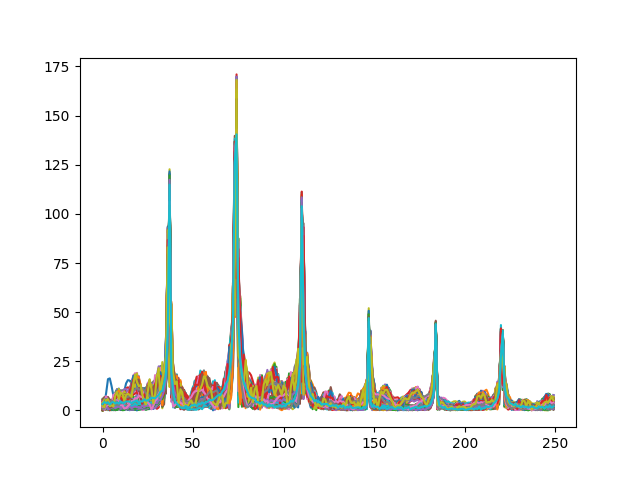

In [19]:
clock_traces_fft = []
trace_list = get_traces('c', 100, 0)
for i in range(100):
    clock_traces_fft.append(get_fft(trace_list[i]))
show_traces(clock_traces_fft)

Ahora que tenemos las transformadas de Fourier por separado, las vamos a sumar para saber cuáles son exactamente los 3 valores predominantes, que serán los que utilizaremos para compararlos con las trazas buenas.

[74, 110, 37]


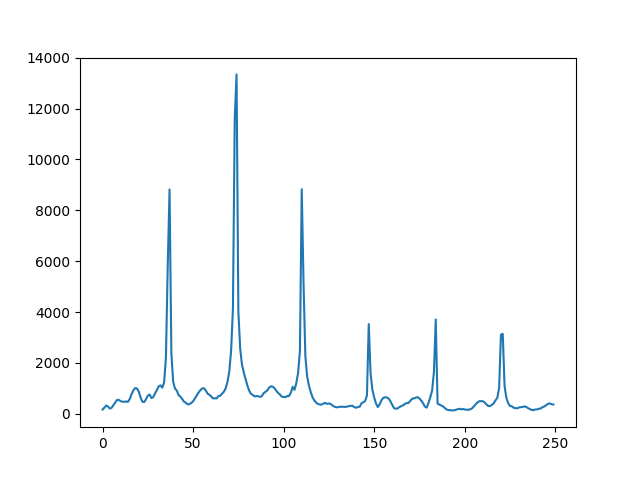

In [20]:
sum_traces = add_traces(clock_traces_fft)
ref_3h = get_3h(sum_traces)
print(ref_3h)
show_trace(sum_traces)

## Obtención de una traza completa

Aquí se obtiene la traza completa que se utilizará. La traza se obtiene uniendo varios segmentos de 20000 valores, y termina cuando la transformada de Fourier de un segmento guarda una fuerte relación con la transformada de Fourier de la señal de reloj calculada previamente.

El bloque siguiente tarda varios minutos en ejecutarse.

In [67]:
offset = 700000
trace_g_blocks = get_traces('d', 30, offset)

In [68]:
trace_g_fft = []
for trace in trace_g_blocks:
    trace_g_fft.append(get_fft(trace))

In [69]:
fft_3h = []
for trace in trace_g_fft:
    fft_3h.append(get_3h(trace))

In [ ]:
for list1 in fft_3h:
    if compare_3h(list1, ref_3h):
        print(offset, list1, "------ Valor aceptado -------")
    else:
        print(offset, list1)
    offset += scope.adc.samples

### Ejecución de decapsulate(), realizando generate_key() y encapsulate() previamente

Tiempo total: 71.76713705062866
Tamaño total: 965000


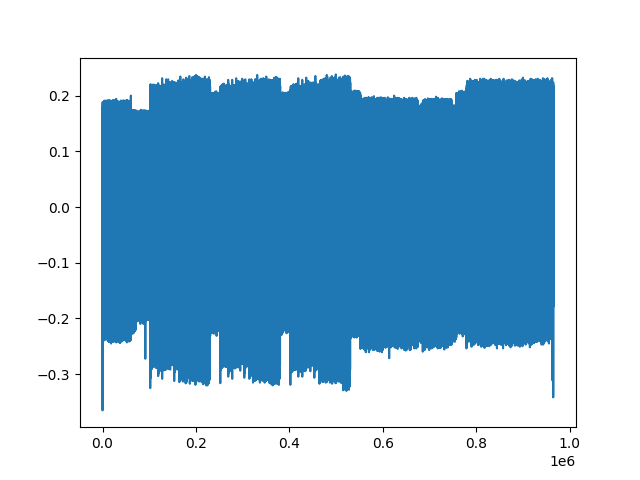

In [21]:
target.simpleserial_write('g', msg)
target.simpleserial_write('e', msg)
start = time.time()
trace_temp = get_total_trace('d', ref_3h)
end = time.time()
print("Tiempo total:", end-start)
print("Tamaño total:", len(trace_temp))
show_trace(trace_temp)

In [22]:
export_trace(trace_temp, "decapsulate/5000/trace_g")

## Paso de secret_key mediante uart

En este apartado enviaré los valores del secret_key calculados previamente mediante uart al chipwhisperer, a través del comando 'i' (insert_sk).

### Generar nuevos valores aleatorios para sk, pk, ct y ss

In [11]:
!./variable_generator

### Introducir valores nuevos en el chipwhisperer

In [37]:
pk = read_hex_file("variables/pk")
write_variable(pk, "pk")
sk = read_hex_file("variables/sk")
write_variable(sk, "sk")
ct = read_hex_file("variables/ct")
write_variable(ct, "ct")
ss = read_hex_file("variables/ss")
write_variable(ss, "ss")

0

### Leer valores nuevos

También comprobamos que la variable dentro del chipwhisperer tiene el mismo valor que la original introducida.

In [38]:
pk_cw = read_variable("pk")
sk_cw = read_variable("sk")
ct_cw = read_variable("ct")
ss_cw = read_variable("ss")
print(pk == pk_cw)
print(sk == sk_cw)
print(ct == ct_cw)
print(ss == ss_cw)

True
True
True
True


## Obtención de las trazas pertenecientes a la operación invntt

Esta es la operación que queremos analizar. La operación se ejecuta entre las muestras 780000 y 990000 del algoritmo decapsulate().

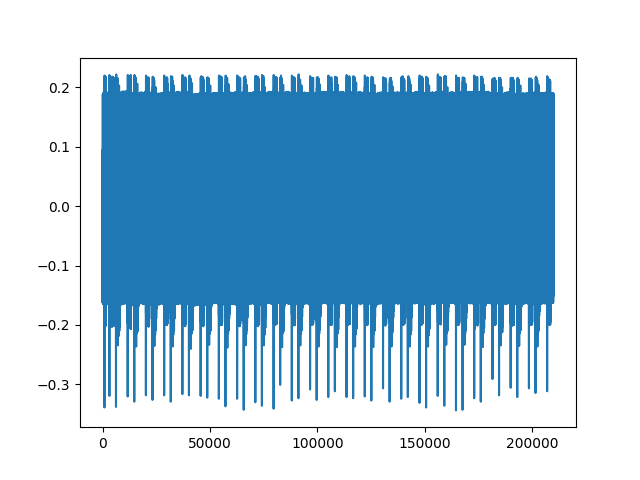

In [21]:
target.simpleserial_write('g', msg)
target.simpleserial_write('e', msg)
offset = 780000
invntt_blocks = get_traces('d', 21, offset)
trace_invntt = join_traces(invntt_blocks)
show_trace(trace_invntt)

## TVLA sobre kyber

En este apartado realizaremos el cálculo TVLA (Test Vector Leakage Assesment) sobre kyber.
Primero empezaremos por cargar los valores canónicos de las variables.

In [8]:
!./variable_generator
write_variables(["pk", "sk", "ct", "ss"])

Una vez hemos cargado las cuatro variables en las posiciones originales, procedemos a realizar el TVLA completo, tomando un total de 1000 muestras que dividiremos en dos grupos: las que corresponden al mensaje cifrado original y las nuevas.

In [ ]:
N_test = 10000
total_blocks = 5 # 5*5000 = 25000 valores
offset = 780000

group1 = []
group2 = []
g1_i = 0
g2_i = 0
TVLA_list = []
TVLA_index = []

start = time.time()
for i in range(N_test):
    if i%100 == 0 and i != 0:
        print(f"{i} trazas depuradas")
    group = random.randint(0,1)
    if group == 0:
        group1.append(join_traces(get_traces('d', total_blocks, offset)))
        g1_i += 1
    elif group == 1:
        !./temp_variable_generator
        write_variables(["pk_temp", "sk_temp", "ct_temp", "ss_temp"])
        group2.append(join_traces(get_traces('t', total_blocks, offset)))
        g2_i += 1
    TVLA_list.append(get_ttest(group1, group2))
    TVLA_index.append(group)
    time.sleep(0.1)
end = time.time()
print("Tiempo total:", end-start)

Ahora podemos exportar las trazas obtenidas

In [46]:
for i in range(len(group1)):
    export_trace(group1[i], "TVLA/10000/group1/trace_"+str(i))
for i in range(len(group2)):
    export_trace(group2[i], "TVLA/10000/group2/trace_"+str(i))
export_trace(TVLA_list, "TVLA/10000/TVLA_list")
export_trace(TVLA_index, "TVLA/10000/TVLA_index")

También podemos observar el resultado obtenido

4978 5022


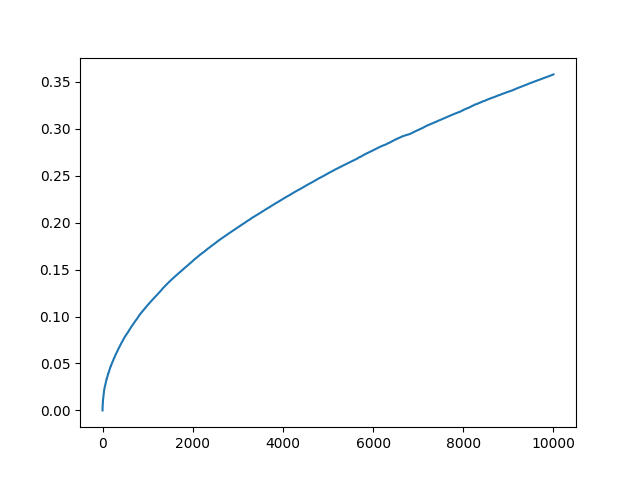

In [50]:
print(len(group1), len(group2))
show_trace(TVLA_list)

## Obtener datos guardados de una ejecución previa

In [7]:
group1 = []
group2 = []
g1_i = count_trace_files("traces/TVLA/10000/group1")
g2_i = count_trace_files("traces/TVLA/10000/group2")

for i in range(g1_i):
    group1.append(read_trace_file("traces/TVLA/10000/group1/trace_"+str(i)))
for i in range(g2_i):
    group2.append(read_trace_file("traces/TVLA/10000/group2/trace_"+str(i)))

TVLA_list = read_trace_file("traces/TVLA/10000/TVLA_list")
TVLA_index = read_trace_file("traces/TVLA/10000/TVLA_index")

print(len(group1[50]), len(group2))
print(get_ttest(group1, group2))

25000 5022
0.3580056497874778


4978 5022
2.148033898724867


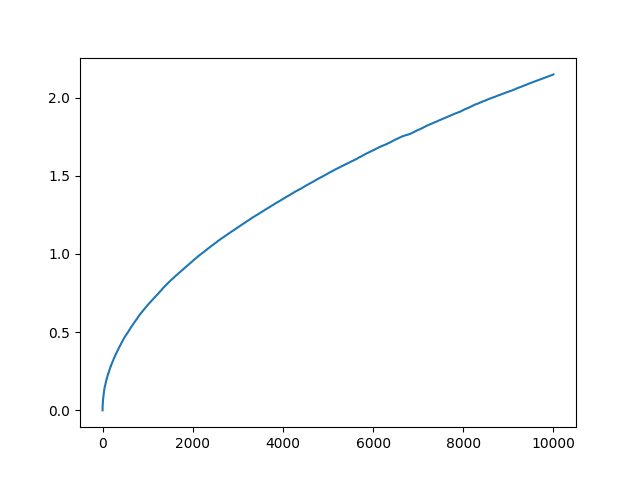

In [8]:
edited_TVLA_list = []
for valor in TVLA_list:
    # if len(edited_TVLA_list) < 200:
        edited_TVLA_list.append(valor*6)
cero = 0
uno = 0
for valor in TVLA_index:
    if valor == 0:
        cero += 1
    elif valor == 1:
        uno += 1
print(cero, uno)
print(max(edited_TVLA_list))
show_trace(edited_TVLA_list)

10000


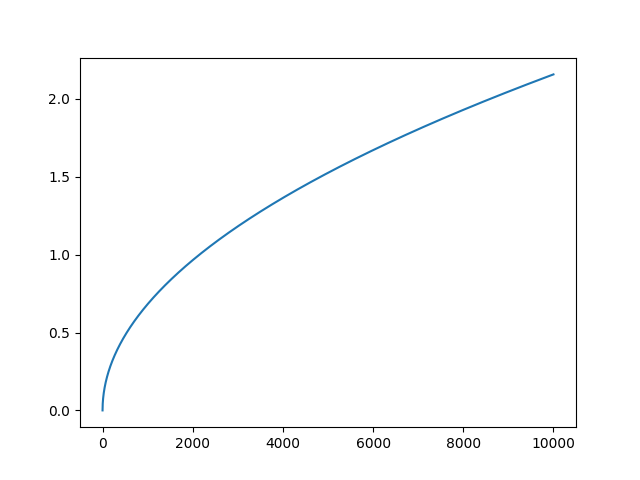

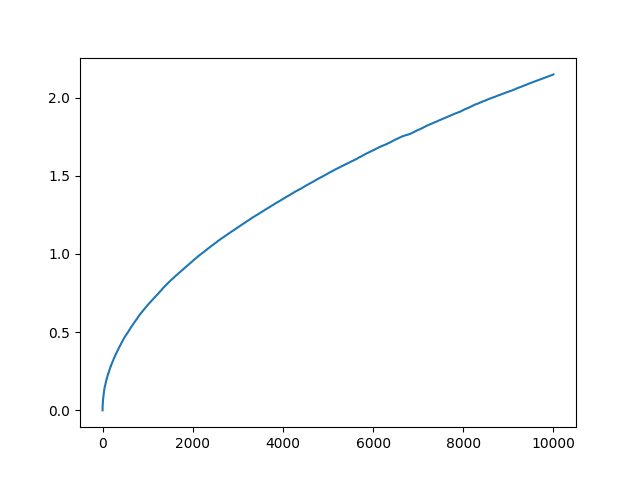

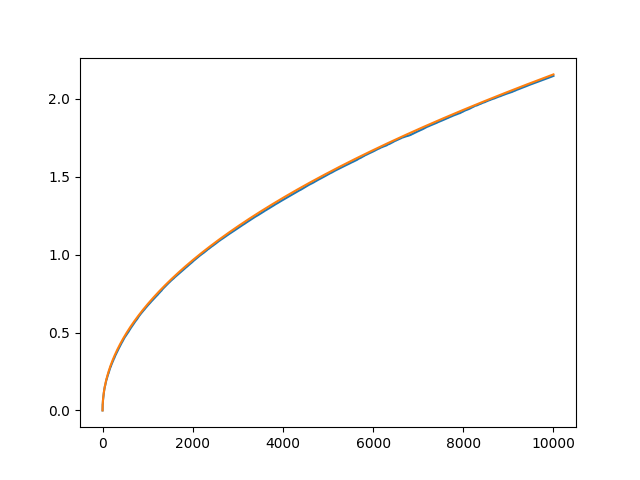

In [48]:
func_irracional = []
for x in range(100000):
    # if np.sqrt(x/2184) < 4.5:
    if len(func_irracional) < 10000:
        func_irracional.append(np.sqrt(x/2148))
print(len(func_irracional))
show_trace(func_irracional)
show_trace(edited_TVLA_list)
show_traces([edited_TVLA_list, func_irracional])

In [44]:
inicio = time.time()
get_ttest(group1, group2)
print(time.time()-inicio)

19.631534337997437


In [45]:
print(edited_TVLA_list[200])
print(func_irracional[200])

0.29405478299416443
0.3051390988486767


In [8]:
group1_np = np.array(group1)
group2_np = np.array(group2)
print(g1_i, g2_i)
print(len(group1_np[4]))
print(group1_np[0])

4978 5022
25000
[ 0.11230469  0.04101562  0.13574219 ... -0.125      -0.00195312
  0.06640625]


Ahora calculamos la media de los dos grupos

In [9]:
mean1 = np.mean(group1, axis=0)
mean2 = np.mean(group2, axis=0)

Superposición de las dos medias. No debería haber gran diferencia ya que en general los valores deberían ser los mismos.

In [ ]:
show_traces([mean1, mean2])

Al realizar la resta entre las dos medias, vemos que los valores efectivamente varían entre ambas trazas. Esto es una buena señal.

0.0006203718159577319 0.020343051963668136


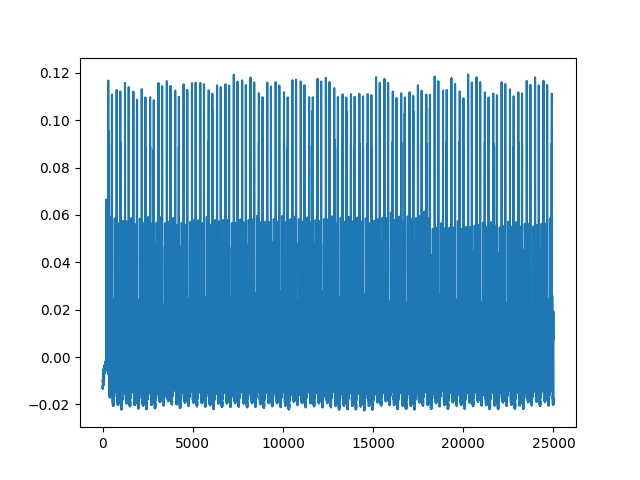

In [14]:
diff_12 = mean1-mean2
print(np.mean(diff_12), np.std(diff_12))
show_trace(diff_12)

5.137064453124998e-05 0.0004487103995799737


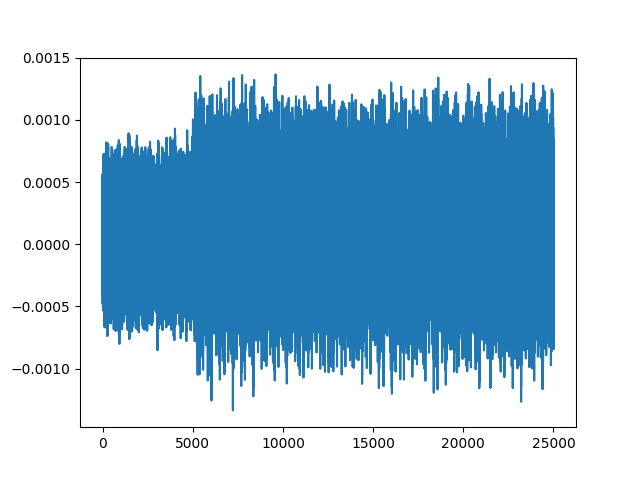

In [15]:
mean1_1 = np.mean(group1[:2000], axis=0)
mean1_2 = np.mean(group1[2000:4000], axis=0)
diff_11 = mean1_1-mean1_2
print(np.mean(diff_11), np.std(diff_11))
show_trace(diff_11)

5.683925781249995e-05 0.0005623713987620019


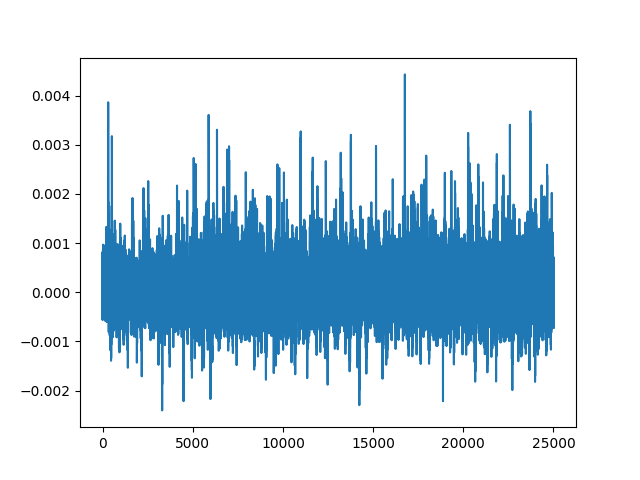

In [21]:
mean2_1 = np.mean(group2[:2000], axis=0)
mean2_2 = np.mean(group2[2000:4000], axis=0)
diff_22 = mean2_1-mean2_2
print(np.mean(diff_22), np.std(diff_22))
show_trace(diff_22)

Aquí ejecutamos el t_test sobre los dos grupos originales.

In [42]:
t_val = ttest_ind(group1_np, group2_np)
show_trace(t_val)

NameError: name 'group1_np' is not defined

### Exportación de trazas

In [40]:
for i in range(len(group1)):
    export_trace(group1[i], "TVLA/group1/trace_"+str(i))
for i in range(len(group2)):
    export_trace(group2[i], "TVLA/group2/trace_"+str(i))

0.03552340776795269


In [23]:
group3_np = np.array(group1[:500])
group4_np = np.array(group1[500:])
print(len(group3_np), len(group4_np))

500 504


In [24]:
mean3 = np.mean(group3_np)
mean4 = np.mean(group4_np)

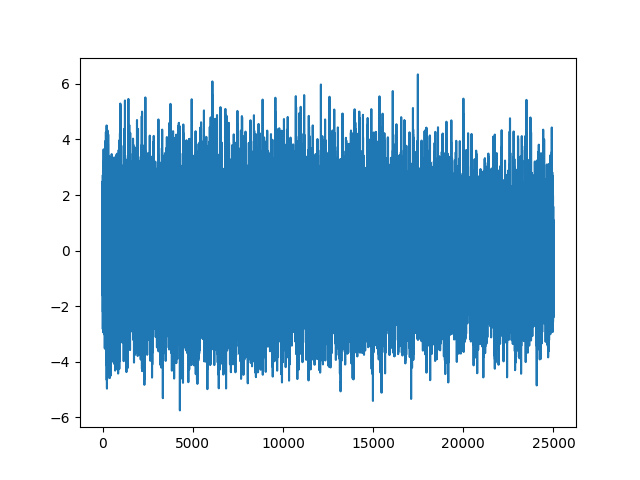

In [25]:
t_val = ttest_ind(group3_np, group4_np, axis=0, equal_var=False)[0]
show_trace(t_val)

In [20]:
total_1 = len(group1)
total_2 = len(group2)
i_1 = 0
i_2 = 0
TVLA_index = []
while i_1 != total_1 or i_2 != total_2:
    TVLA_index = []
    i_1 = 0
    i_2 = 0
    for i in range(2000):
        valor = random.randint(0, 1)
        TVLA_index.append(valor)
        if valor == 0:
            i_1 += 1
        elif valor == 1:
            i_2 += 1

In [65]:
def get_ttest(group1, group2):
    if len(group1) == 0 or len(group2) == 0:
        return 0
    mean_1 = np.mean(group1, axis=0)
    mean_2 = np.mean(group2, axis=0)
    var_1 = np.var(group1, axis=0)
    var_2 = np.var(group2, axis=0)
    n_1 = len(group1)
    n_2 = len(group2)
    ttest = (mean_1-mean_2)/(np.sqrt((var_1/n_1)+(var_2/n_2)))
    return ttest

In [29]:
i_1 = 0
i_2 = 0
TVLA_list = []
for valor in TVLA_index:
    TVLA_list.append(get_ttest(group1[:i_1], group2[:i_2]))
    if valor == 0:
        i_1 += 1
    elif valor == 1:
        i_2 += 1

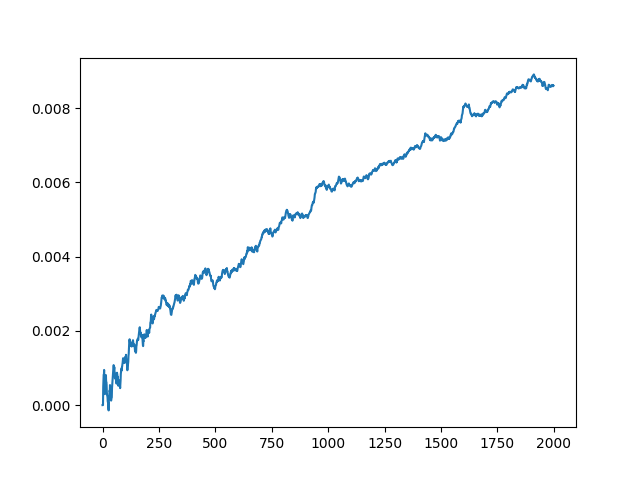

In [30]:
show_trace(TVLA_list)

In [31]:
export_trace(TVLA_list, "TVLA_1")

In [88]:
res = scipy_ttest(group1[:7], group2[:7])
print(res)

(1.959470675343714, 0.05005848913659982)
